# Greedy basis assembly using DMRG

As a follow-up example, we now want to showcase how to compute a reduced basis by means
of the [density matrix renormalization group](https://tensornetwork.org/mps/algorithms/dmrg/)
(DMRG). To that end, we utilize the [ITensors.jl](https://itensor.github.io/ITensors.jl/stable/)
package which, among other things, efficiently implements DMRG. We will see that, while
we need to adjust the way we set up the model Hamiltonian as well as our solver, most
steps stay the same. Again, we treat the one-dimensional $S=1/2$ XXZ model from the
previous example.

## Hamiltonians as `MPO`s

Let us begin by building the XXZ Hamiltonian. Instead of constructing explicit matrices
from Kronecker products as we did before, we now use a tensor format called
*matrix product operators* (MPOs) to represent the Hamiltonian.

!!! note "Random seed"
    In order to make the automatically generated documentation examples that utilize
    `ITensors` and in particular random initial states consistent and deterministic,
    we initialize the random number generator by calling `Random.seed!`.

In [1]:
using ITensors
using ReducedBasis
using Random: seed!
seed!(0);

To build the Hamiltonian terms as MPOs, we make use of the `ITensors.OpSum()` object that
automatically produces a MPO from a string of operators. The affine MPO terms are then
stored in an `AffineDecomposition` as `ApproxMPO`s which also include
possible truncation keyword arguments:

In [2]:
function xxz_chain(sites::IndexSet; kwargs...)
    xy_term   = OpSum()
    zz_term   = OpSum()
    magn_term = OpSum()
    for i in 1:(length(sites) - 1)
        xy_term   += "Sx", i, "Sx", i + 1
        xy_term   += "Sy", i, "Sy", i + 1
        zz_term   += "Sz", i, "Sz", i + 1
        magn_term += "Sz", i
    end
    magn_term += "Sz", length(sites)  # Add last magnetization term
    AffineDecomposition([ApproxMPO(MPO(xy_term, sites), xy_term; kwargs...),
                         ApproxMPO(MPO(zz_term, sites), zz_term; kwargs...),
                         ApproxMPO(MPO(magn_term, sites), magn_term; kwargs...)],
                        μ -> [1.0, μ[1], -μ[2]])
end;

So let us instantiate such a MPO Hamiltonian where we also specify a singular value
`cutoff`, which is passed to the `ApproxMPO` objects:

In [3]:
L = 12
sites = siteinds("S=1/2", L)
H = xxz_chain(sites; cutoff=1e-9);

Notice that we can now choose a bigger system size (which is still very small here),
since the tensor format allows for efficient low rank approximations (hence the `cutoff`)
that buy us a substantial performance advantage when going to larger systems.

## Using the `DMRG` solver for obtaining snapshots

Having created our Hamiltonian in MPO format, we now need a solver that is able to compute
ground states from MPOs. The corresponding ground state will also be obtained in a tensor
format, namely as a *matrix product state* (MPS). This is achieved by `ITensors.dmrg`
which is wrapped in the `DMRG` solver type:

In [4]:
dm = DMRG(; sweeps=default_sweeps(; cutoff_max=1e-9),
          observer=() -> DMRGObserver(; energy_tol=1e-9));

For each solve a new `ITensors.DMRGObserver` object is created that converges the DMRG
iteration up the specified `energy_tol`. The sweeps argument takes any `ITensors.Sweeps`
object that controls the approximation settings with respect to the DMRG sweeps.
While the implemented DMRG solver is capable of also solving degenerate ground states,
we here opt for non-degenerate DMRG settings (see the `n_states` and `tol_degeneracy`
keyword arguments in `DMRG`) which is the default behavior. (We do
this due to a $L+1$-fold degeneracy on the parameter domain, where the degenerate DMRG
solver can produce instable results for larger $L$.)

As discussed in the last example, we need a way to orthogonalize the reduced basis. Due to
the MPS format that the snapshots will have, we cannot use QR decompositions anymore and
resort to a different method, `EigenDecomposition`, featuring an eigenvalue
decomposition of the snapshot overlap matrix that can drop insignificant snapshots that
fall below a cutoff:

In [5]:
edcomp = EigenDecomposition(; cutoff=1e-7);

Now with different types for the Hamiltonian, the solver and the orthogonalizer, we call
`assemble` using the `greedy` strategy and training grid from the last example. However,
instead of specifying a tolerance for the maximal error estimate of our basis, we now set
a maximal number of performed truth solves via `n_truth_max`:

In [6]:
Δ = range(-1.0, 2.5; length=40)
hJ = range(0.0, 3.5; length=40)
grid_train = RegularGrid(Δ, hJ)
greedy = Greedy(; estimator=Residual(), n_truth_max=24)

rbres = assemble(H, grid_train, greedy, dm, edcomp);

n      max. err    ‖BᵀB-I‖     time      μ       
------------------------------------------------------------
1      NaN         0            60.4s    [-1.0, 0.0]
2      6.3         2.22e-16     2.28s    [2.5, 3.5]
3      3.36        5.1e-16      4.30s    [2.5, 0.538]
4      1.52        7.53e-15     781ms    [-0.282, 0.09]
5      1.87        3.25e-14     342ms    [2.5, 2.513]
6      0.934       3.88e-15     844ms    [0.795, 0.0]
7      0.726       7.16e-15     389ms    [0.077, 0.718]
8      0.868       5.83e-15     364ms    [2.5, 3.141]
9      0.723       9.25e-15     360ms    [0.795, 0.538]
10     0.814       1.88e-14     405ms    [2.5, 0.897]
11     0.708       1.37e-14     391ms    [2.051, 2.423]
12     0.538       7.98e-14     414ms    [0.705, 0.897]
13     0.443       4.3e-14      516ms    [-0.103, 0.0]
14     0.274       5.15e-14     505ms    [-0.372, 0.269]
15     0.233       6.85e-14     1.18s    [-0.91, 0.0]
16     0.229       7.53e-14     516ms    [-0.462, 0.449]
17     0.11

The returned `basis` now has snapshot vectors of `ITensors.MPS` type, which we have to
keep in mind when we want to compress observables. That is to say, the observables have
to be constructed as `AffineDecomposition`s with `ApproxMPO` terms as
we did for the Hamiltonian. Again, we want to compute the magnetization so that we can
reuse the third term of `H`:

In [7]:
M    = AffineDecomposition([H.terms[3]], [2 / L])
m, _ = compress(M, rbres.basis);

And at that point, we continue as before since we have arrived at the online phase where
we only operate in the low-dimensional RB space, agnostic of the snapshot
solver method. We have to make sure, however, to choose matching degeneracy settings for
the `FullDiagonalization` solver in the online phase:

In [8]:
fulldiag = FullDiagonalization(dm);

Then we can define an online grid and compute the magnetization at all grid points, again
constructing `m` at an arbitrary parameter point since its coefficient is
parameter-independent:

In [9]:
m_reduced = m()
Δ_online = range(first(Δ), last(Δ); length=100)
hJ_online = range(first(hJ), last(hJ); length=100)
grid_online = RegularGrid(Δ_online, hJ_online)

using Statistics
magnetization = map(grid_online) do μ
    _, φ_rb = solve(rbres.h, rbres.basis.metric, μ, fulldiag)
    mean(u -> abs(dot(u, m_reduced, u)), eachcol(φ_rb))
end;

Plotting the `magnetization` on a heatmap, we arrive at the following result:

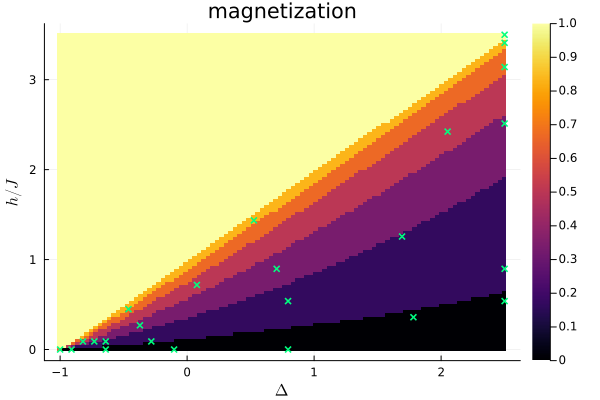

In [10]:
using Plots
hm = heatmap(grid_online.ranges[1], grid_online.ranges[2], magnetization';
             xlabel=raw"$\Delta$", ylabel=raw"$h/J$", title="magnetization",
             colorbar=true, clims=(0.0, 1.0), leg=false)
params = unique(rbres.basis.parameters)
scatter!(hm, [μ[1] for μ in params], [μ[2] for μ in params];
         markershape=:xcross, color=:springgreen, ms=3.0, msw=2.0)

We reproduce the ground-state phase diagram, but this time with more magnetization
plateaus (due to increased system size) and we see that the greedy algorithm chose
different parameter points to solve using DMRG.